## Explicação da Triplet Loss

### 1. Três imagens como entrada:
A **Triplet Loss** trabalha com três imagens:

- **Âncora (Anchor):** Uma imagem de referência.
- **Positiva (Positive):** Uma imagem da mesma classe/categoria da âncora.
- **Negativa (Negative):** Uma imagem de uma classe/categoria diferente da âncora.

### 2. Passagem pela mesma CNN:
As três imagens são passadas pela **mesma rede neural convolucional (CNN)**, e a CNN compartilha **os mesmos pesos e viéses**. Isso significa que a rede é **siamese** ou **compartilhada**, garantindo que as representações aprendidas sejam consistentes.

### 3. Geração de vetores de características:
Após passar pela CNN, cada imagem é transformada em um **vetor de características** ou **embedding**:

- \( f(a) \): O vetor de características da **âncora**.
- \( f(p) \): O vetor de características da **positiva**.
- \( f(n) \): O vetor de características da **negativa**.

### 4. Cálculo da Triplet Loss:
A função **Triplet Loss** tem como objetivo garantir que:

- A distância entre a âncora \( f(a) \) e a positiva \( f(p) \) seja **menor**.
- A distância entre a âncora \( f(a) \) e a negativa \( f(n) \) seja **maior**, por pelo menos uma margem \( \alpha \).

A fórmula da **Triplet Loss** é:

$$
L(a, p, n) = \max(0, ||f(a) - f(p)||^2 - ||f(a) - f(n)||^2 + \alpha)
$$

Aqui:
- \( ||f(a) - f(p)||^2 \) é a distância entre a âncora e a positiva.
- \( ||f(a) - f(n)||^2 \) é a distância entre a âncora e a negativa.
- \( \alpha \) é uma margem que controla o quão distantes as classes devem estar.

### Resumo:
1. A Triplet Loss recebe 3 imagens: **Âncora**, **Positiva** e **Negativa**.
2. Todas as imagens passam pela **mesma CNN**, que compartilha pesos e viéses.
3. A CNN gera **3 vetores de características**, um para cada imagem. A loss é calculada para aproximar imagens da mesma classe e afastar imagens de classes diferentes.


## 1. Setup

### 1.1 Instalar dependencias

In [ ]:
#!pip install -r requirements.txt

### 1.2 Importar Dependencias

In [427]:
import os
import random
from tqdm import tqdm
import numpy as np
from termcolor import colored
import matplotlib.pyplot as plt
from PIL import Image
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, Model, Input
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score

## 2. Criar os Triplets

In [308]:
def create_triplets(data_dir):
    anchor_paths = []
    positive_paths = []
    negative_paths = []
    
    people= os.listdir(data_dir)
    
    for person in people:
        anchor_dir = os.path.join(data_dir, person, 'anchor')
        positive_dir = os.path.join(data_dir, person, 'positive')
        negative_dir = os.path.join(data_dir, person, 'negative')
        
        if (not os.path.exists(anchor_dir) or not os.listdir(anchor_dir) or not os.path.exists(positive_dir) or 
            not os.listdir(positive_dir) or not os.path.exists(negative_dir) or not os.listdir(negative_dir)):
            continue
        
        anchor_images = os.listdir(anchor_dir)
        positive_images = os.listdir(positive_dir)
        negative_images = os.listdir(negative_dir)
        
        for anchor in anchor_images:
            anchor_path = os.path.join(anchor_dir, anchor)
            positive = random.choice(positive_images)
            positive_path = os.path.join(positive_dir, positive)
            negative = random.choice(negative_images)
            negative_path = os.path.join(negative_dir, negative)
            
            anchor_paths.append(anchor_path)
            positive_paths.append(positive_path)
            negative_paths.append(negative_path)
    
    return anchor_paths, positive_paths, negative_paths

In [309]:
data_dir = "dataset_cropado" #path of your preprocess folder you have created by above code
anchor_paths, positive_paths, negative_paths = create_triplets(data_dir)

In [310]:
len(positive_paths), len(anchor_paths), len(negative_paths)

(3474, 3474, 3474)

In [311]:
anchor_paths[0]

'dataset_final/preprocess\\Aaron_Eckhart\\anchor\\Aaron_Eckhart_0001_0000.jpg'

In [312]:
def show_triplets(anchor_paths, positive_paths, negative_paths, num_samples=3):
    for i in range(num_samples):
        fig, axs = plt.subplots(1, 3, figsize=(10, 4))
        
        anchor_img = Image.open(anchor_paths[i])
        positive_img = Image.open(positive_paths[i])
        negative_img = Image.open(negative_paths[i])
        
        axs[0].imshow(anchor_img)
        axs[0].set_title("Anchor")
        axs[0].axis('off')
        
        axs[1].imshow(positive_img)
        axs[1].set_title("Positive")
        axs[1].axis('off')
        
        axs[2].imshow(negative_img)
        axs[2].set_title("Negative")
        axs[2].axis('off')
        
        plt.show()

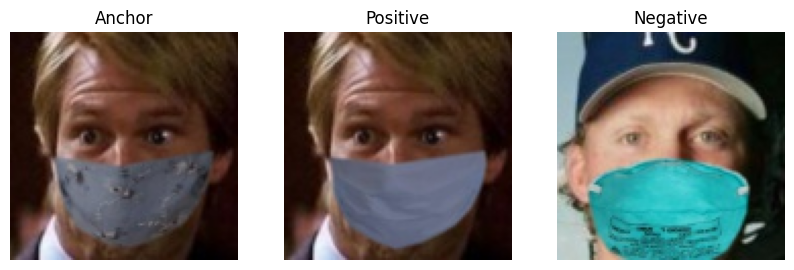

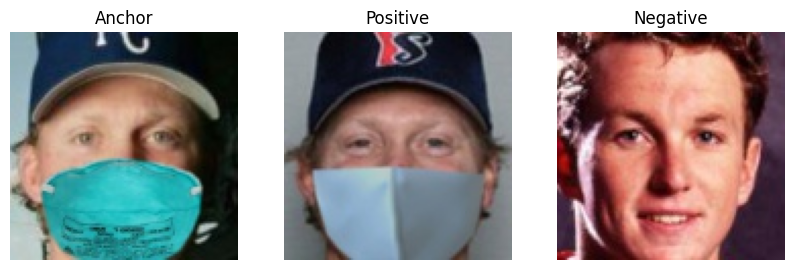

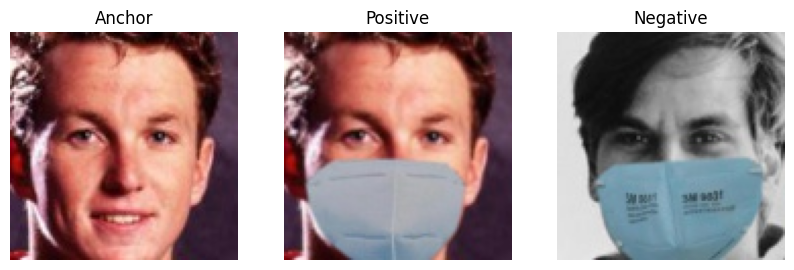

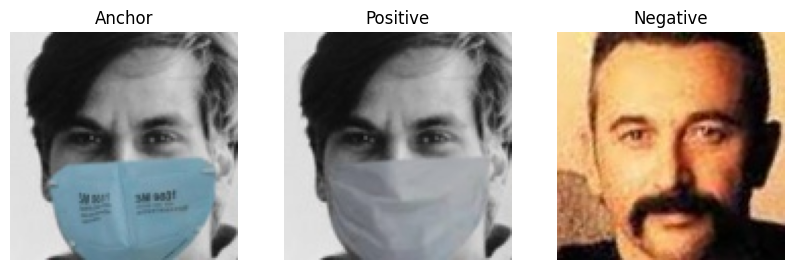

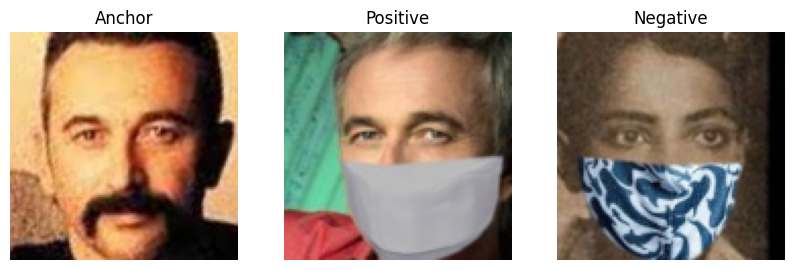

In [313]:
show_triplets(anchor_paths, positive_paths, negative_paths)

## 3 Criar conjuntos de dados do TensorFlow

In [332]:
def preprocess(file_path):
    # realiza a leitura de um arquivo de imagem a partir de um caminho especificado (file_path) e retorna o conteúdo do arquivo como um tensor de bytes. 
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img) # Decodifique a imagem para obter um tensor com o conteúdo da imagem.
    img = tf.image.resize(img, (112, 112))
    img = img / 255.0
    return img

In [333]:
# Criar um dataset de tripletos a partir de listas de caminhos de imagens
anchor_ds = tf.data.Dataset.from_tensor_slices(anchor_paths)
positive_ds = tf.data.Dataset.from_tensor_slices(positive_paths)
negative_ds = tf.data.Dataset.from_tensor_slices(negative_paths)

# Combina os três datasets
triplets = tf.data.Dataset.zip((anchor_ds, positive_ds, negative_ds))

In [334]:
# Estou aplicando uma função preprocess em todo o dataset triplets
preprocessed_triplets = triplets.map(lambda anchor, positive, negative: (preprocess(anchor), preprocess(positive), preprocess(negative)))

In [338]:
# Ainda não dividir, so é o calculo do meus dados em 70% para treino, 15% para validação e o resto para test
train_size = int(0.7 * len(preprocessed_triplets))
val_size = int(0.2 * len(preprocessed_triplets))
test_size = len(preprocessed_triplets) - train_size - val_size

In [339]:
train_size, val_size, test_size

(2431, 694, 349)

In [340]:
# embaralha os elementos aleatoriamente do dataset
shuffled_triplets = preprocessed_triplets.shuffle(buffer_size=len(preprocessed_triplets))

# é usada para criar o conjunto de treino a partir do dataset embaralhado shuffled_triplets
# O método .take(n) é utilizado para criar um novo dataset contendo apenas os primeiros n elementos do dataset original shuffled_triplets.
# train_size: Especifica o número de elementos a serem selecionados para o conjunto de treino.
# Este valor foi calculado anteriormente como 70% do total de elementos no dataset original.
train_dataset = shuffled_triplets.take(train_size)

# é usada para criar um dataset contendo todos os elementos restantes após a alocação para o conjunto de treino.
#nO método .skip(n) é utilizado para criar um novo dataset que ignora os primeiros n elementos do dataset original shuffled_triplets.
val_test_dataset = shuffled_triplets.skip(train_size)

# Faz a mesma coisa em relação ao train_dataset
val_dataset = val_test_dataset.take(val_size)
test_dataset = val_test_dataset.skip(val_size)

In [341]:
'''
Essa linha de código aplica várias otimizações de desempenho ao dataset usando a API tf.data do TensorFlow. Vamos detalhar o que cada método faz:

cache():

O que faz: Armazena em cache os dados do dataset em memória (ou no disco, se especificado) após o primeiro carregamento. Isso evita que o dataset seja carregado
 repetidamente em cada época, economizando tempo de leitura e processamento para as épocas subsequentes.
Uso: Ideal para datasets que cabem na memória, melhorando o desempenho ao evitar leituras repetidas do disco.
batch(16):

O que faz: Agrupa os dados em batches de tamanho 16. Isso significa que o modelo será treinado usando 16 amostras por vez.
Uso: Facilita o processamento paralelo e a atualização dos pesos do modelo com base em um grupo de exemplos, o que pode melhorar a eficiência do treinamento.
prefetch(buffer_size=tf.data.experimental.AUTOTUNE):

O que faz: Permite que o dataset carregue e prepare os dados em paralelo enquanto o modelo está treinando com o batch atual. AUTOTUNE faz com que o TensorFlow ajuste 
automaticamente o tamanho do buffer de pré-carregamento para otimizar o desempenho.
Uso: Reduz o tempo ocioso do modelo esperando que os dados sejam carregados, melhorando a eficiência do treinamento e a utilização dos recursos de CPU/GPU.
Em resumo, a linha de código aplica as seguintes otimizações ao dataset:

Armazenamento em cache dos dados para evitar carregamento repetido.
Agrupamento dos dados em batches de 16 para processamento eficiente.
Pré-carregamento dos dados enquanto o modelo está treinando para reduzir o tempo de espera.
Essas técnicas ajudam a melhorar o desempenho do treinamento, reduzindo o tempo de processamento e aproveitando melhor os recursos computacionais disponíveis.
'''

train_dataset = train_dataset.cache().batch(16).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.cache().batch(16).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.cache().batch(16).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


In [342]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 112, 112, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 112, 112, None), dtype=tf.float32, name=None), TensorSpec(shape=(None, 112, 112, None), dtype=tf.float32, name=None))>

## 4. Inicializa o MobileNet

## Explicação do Modelo de Embedding com MobileNetV2

### 1. **Base do Modelo: MobileNetV2**
- A **MobileNetV2** é uma rede convolucional pré-treinada no dataset **ImageNet**, que foi projetada para ser eficiente em termos de computação, permitindo o uso em dispositivos móveis.
- Usamos a MobileNetV2 como a base do nosso modelo de embedding, removendo sua última camada totalmente conectada (`include_top=False`), já que ela foi projetada para classificação de 1000 classes do ImageNet, e aqui estamos interessados em obter um vetor de características (embedding) para as imagens.
- Mantemos os **pesos congelados** (parâmetro `trainable=False`), o que significa que durante o treinamento, os pesos dessa parte da rede não serão ajustados, evitando a sobrecarga de treinamento e garantindo que as features aprendidas previamente pela MobileNetV2 sejam preservadas.

### 2. **Arquitetura do Modelo**
#### Entrada:
- O modelo recebe imagens de entrada com a forma `input_shape=(112, 112, 3)`, ou seja, imagens coloridas com 112 pixels de altura e largura, e 3 canais (RGB).

#### Extração de Embeddings:
- A imagem de entrada é passada pela **MobileNetV2**, que gera um **mapa de características** (ou feature map), representando as principais características extraídas da imagem.
- Em seguida, aplicamos a camada de **GlobalAveragePooling2D**, que transforma o mapa de características bidimensional em um vetor de menor dimensão, consolidando a informação espacial.

#### Camadas Densas e Regularização:
- O vetor de características gerado pela MobileNetV2 é então passado por uma série de camadas densas para refinar e aprender a representação final (embedding):
  - **Camada Densa 1:** 64 unidades com ativação **ReLU**.
  - **Dropout 1:** 40% de unidades desligadas aleatoriamente para prevenir overfitting.
  - **Batch Normalization 1:** Normalização para estabilizar o processo de treinamento.
  - **Camada Densa 2:** 32 unidades com ativação **ReLU**.
  - **Dropout 2:** 40% de unidades desligadas aleatoriamente para prevenir overfitting.
  - **Batch Normalization 2:** Normalização novamente aplicada para melhorar a generalização.

#### Saída:
- A camada de saída gera um **vetor de 16 dimensões**, que será usado como o **embedding final** da imagem. Este vetor é a representação compacta da imagem que pode ser usada para diversas tarefas, como similaridade de imagens ou classificação com outra rede.

### 3. **Resumo do Modelo:**
- A arquitetura do modelo foi desenhada para que as imagens passem primeiro por uma CNN pré-treinada e, em seguida, tenham sua dimensionalidade reduzida, resultando em um vetor de características útil.
- O modelo não apenas extrai características ricas da MobileNetV2, mas também aplica camadas densas para refinar o embedding com regularização através de **Dropout** e **Batch Normalization**.

### 4. **Uso do Modelo:**
- Esse modelo pode ser utilizado para criar embeddings de imagens, que podem ser comparados com embeddings de outras imagens (usando, por exemplo, a **Triplet Loss**).
- O embedding gerado é compacto (apenas 16 dimensões) e captura as principais informações da imagem.


In [343]:
def get_embedding_model(input_shape=(112, 112, 3)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False 

    inputs = layers.Input(shape=input_shape)
    
    embeddings = base_model(inputs)
    embeddings = layers.GlobalAveragePooling2D()(embeddings)  # Pooling para reduzir as dimensões
    
    # Adicionar camadas densas para o aprendizado da representação (embedding)
    x = layers.Dense(units=64, activation="relu")(embeddings)
    x = layers.Dropout(0.4)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(units=32, activation="relu")(x)
    x = layers.Dropout(0.4)(x)
    x = layers.BatchNormalization()(x)
    
    outputs = layers.Dense(units=16)(x)
    
    embedding_model = Model(inputs=inputs, outputs=outputs, name="embedding_model")
    return embedding_model


In [344]:
embedding_model = get_embedding_model()
embedding_model.summary()


C:\Users\amissadai.pinheiro\AppData\Local\Temp\ipykernel_10796\1030010658.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Model: "embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_50 (InputLayer)     │ (None, 112, 112, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_8      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_105 (Dense)               │ (None, 64)             │        81,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_106 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_107 (Dense)               │ (None, 16)             │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,342,960 (8.94 MB)

 Trainable params: 84,784 (331.19 KB)

 Non-trainable params: 2,258,176 (8.61 MB)

## 5. Triplet Loss Function

![Imagem](triplet_loss.jpg)

A função **Triplet Loss** é definida como:

$$
L(a, p, n) = \max(0, ||f(a) - f(p)||^2 - ||f(a) - f(n)||^2 + \alpha)
$$

Onde:
- \( a \) é a âncora (anchor).
- \( p \) é um exemplo positivo (positive).
- \( n \) é um exemplo negativo (negative).
- \( \alpha \) é a margem (margin).
- \( f(\cdot) \) representa a função de embedding.



In [345]:
def triplet_loss(y_pred, margin=0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    basic_loss = pos_dist - neg_dist + margin
    loss = tf.maximum(basic_loss, 0.0)
    return tf.reduce_mean(loss)


## 6. Building Network

## Rede Siamesa (Triplet Network)

### 1. **Arquitetura da Rede Siamesa**
A função `get_network` cria uma rede siamesa que utiliza o modelo de **embedding** definido anteriormente no capitulo 4 para processar três imagens simultaneamente: uma imagem **âncora** (*anchor*), uma imagem **positiva** (*positive*) e uma imagem **negativa** (*negative*).

#### Entrada:
- **anchor_input:** Imagem de entrada âncora, que serve como referência para comparação com as outras duas.
- **positive_input:** Imagem semelhante à âncora, ou seja, elas devem pertencer à mesma classe.
- **negative_input:** Imagem que não pertence à mesma classe da âncora, servindo como contraste.
- Cada uma das entradas tem o mesmo formato, `input_shape=(112, 112, 3)`, que representa imagens coloridas (3 canais: RGB) com 112x112 pixels.

### 2. **Processamento de Embeddings**
Cada uma das três imagens de entrada (âncora, positiva e negativa) é passada pelo **modelo de embedding** que foi previamente definido:
- **anchor_embedding:** A imagem de âncora passa pelo modelo de embedding para gerar um vetor de características que descreve essa imagem.
- **positive_embedding:** A imagem positiva, que é similar à âncora, também é convertida em um vetor de características.
- **negative_embedding:** A imagem negativa, que é diferente da âncora, gera seu próprio vetor de características.

### 3. **Modelo Siamesa**
O modelo siamesa é construído com três entradas (âncora, positiva e negativa) e três saídas, correspondentes aos vetores de embedding dessas imagens.
- As três entradas são processadas de forma independente, mas com o **mesmo modelo de embedding** que compartilha pesos, garantindo que a mesma rede seja usada para todas as imagens.
- A rede siamesa **não treina os embeddings separadamente** para cada imagem. Pelo contrário, as três imagens compartilham os mesmos pesos e parâmetros da rede de embedding, o que é um princípio fundamental de redes siamesas.

### 4. **Triplet Loss**
Esse modelo siamesa é normalmente usado com a **Triplet Loss**, uma função de perda que força o modelo a minimizar a distância entre a âncora e a imagem positiva, enquanto maximiza a distância entre a âncora e a imagem negativa:
- A Triplet Loss garante que as imagens positivas estejam mais próximas da âncora no espaço de embeddings do que as imagens negativas.
  
### 5. **Resumo da Arquitetura**:
- **Entradas:** 3 imagens de entrada (âncora, positiva e negativa).
- **Saídas:** 3 vetores de embedding, cada um correspondente às imagens de entrada.
- O modelo final treina de forma conjunta para ajustar os embeddings, de modo que as imagens similares estejam próximas umas das outras no espaço de características e as imagens diferentes estejam distantes.


In [346]:
def get_network(embedding_model, input_shape=(112, 112, 3)):
    anchor_input = Input(name="anchor", shape=input_shape)
    positive_input = Input(name="positive", shape=input_shape)
    negative_input = Input(name="negative", shape=input_shape)
    
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)
    
    siamese_network = Model(
        inputs=[anchor_input, positive_input, negative_input],
        outputs=[anchor_embedding, positive_embedding, negative_embedding]
    )
    
    return siamese_network


In [347]:
siamese_network = get_network(embedding_model)
siamese_network.summary()


Model: "functional_40"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer) │ (None, 112, 112,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive            │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative            │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_model     │ (None, 16)        │  2,342,960 │ anchor[0][0],     │
│ (Functional)        │                   │            │ positive[0][0],   │
│                     │                   │            │ negative[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,342,960 (8.94 MB)

 Trainable params: 84,784 (331.19 KB)

 Non-trainable params: 2,258,176 (8.61 MB)

In [351]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_network)

def siamese_train_step(siamese_network, optimizer, data, margin=0.2):
    anchor, positive, negative = data

    with tf.GradientTape() as tape:
        anchor_embedding, positive_embedding, negative_embedding = siamese_network((anchor, positive, negative))
        loss = triplet_loss([anchor_embedding, positive_embedding, negative_embedding], margin=margin)
        
    gradients = tape.gradient(loss, siamese_network.trainable_variables)
    optimizer.apply_gradients(zip(gradients, siamese_network.trainable_variables))

    return loss

In [352]:
def train_siamese_network(siamese_network, optimizer, train_dataset, num_epochs, margin=0.2):
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        epoch_accuracy = tf.keras.metrics.BinaryAccuracy()
        
        with tqdm(total=len(train_dataset), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
            for data in train_dataset:
                loss = siamese_train_step(siamese_network, optimizer, data, margin)
                epoch_loss += loss
                
                anchor_embedding, positive_embedding, negative_embedding = siamese_network(data)
                pos_dist = tf.norm(anchor_embedding - positive_embedding, axis=-1)
                neg_dist = tf.norm(anchor_embedding - negative_embedding, axis=-1)
                accuracy = tf.cast(pos_dist < neg_dist, tf.float32)
                
                epoch_accuracy.update_state(tf.ones_like(accuracy), accuracy)
                
                pbar.update(1)
                pbar.set_postfix({'loss': loss.numpy(), 'accuracy': accuracy.numpy()})
                
            epoch_loss /= len(train_dataset)
            acc_value = epoch_accuracy.result().numpy()
            print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {acc_value:.4f}')
            
            epoch_accuracy.reset_state()    

In [353]:
num_epochs = 10
margin = 0.2 # Por padrão é 0.2

train_siamese_network(siamese_network, opt, train_dataset, num_epochs, margin)

Epoch 1/10: 100%|██████████| 152/152 [10:07<00:00,  4.10s/batch, loss=0.184, accuracy=[1. 0. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1.]]    

Epoch 1/10, Loss: 0.5619, Accuracy: 0.6594


Epoch 2/10: 100%|██████████| 152/152 [09:51<00:00,  3.95s/batch, loss=0.21, accuracy=[0. 0. 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1.]]     

Epoch 2/10, Loss: 0.1545, Accuracy: 0.6927


Epoch 3/10: 100%|██████████| 152/152 [09:50<00:00,  3.98s/batch, loss=0.145, accuracy=[1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1. 1.]]    

Epoch 3/10, Loss: 0.1208, Accuracy: 0.7709


Epoch 4/10: 100%|██████████| 152/152 [09:50<00:00,  4.00s/batch, loss=0.0776, accuracy=[1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]]    

Epoch 4/10, Loss: 0.1024, Accuracy: 0.8137


Epoch 5/10: 100%|██████████| 152/152 [09:51<00:00,  3.96s/batch, loss=0.0824, accuracy=[1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.]]   

Epoch 5/10, Loss: 0.0856, Accuracy: 0.8466


Epoch 6/10: 100%|██████████| 152/152 [09:51<00:00,  3.97s/batch, loss=0.044, accuracy=[1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]     

Epoch 6/10, Loss: 0.0691, Accuracy: 0.8955


Epoch 7/10: 100%|██████████| 152/152 [10:05<00:00,  4.17s/batch, loss=0.0631, accuracy=[0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]]    

Epoch 7/10, Loss: 0.0651, Accuracy: 0.8980


Epoch 8/10: 100%|██████████| 152/152 [10:13<00:00,  3.81s/batch, loss=0.0297, accuracy=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.]]    

Epoch 8/10, Loss: 0.0462, Accuracy: 0.9321


Epoch 9/10: 100%|██████████| 152/152 [09:44<00:00,  4.27s/batch, loss=0.0303, accuracy=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]    

Epoch 9/10, Loss: 0.0428, Accuracy: 0.9420


Epoch 10/10: 100%|██████████| 152/152 [09:57<00:00,  3.93s/batch, loss=0, accuracy=[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]          

Epoch 10/10, Loss: 0.0449, Accuracy: 0.9399


## Evaluating the Model

## Cálculo de Métricas de Desempenho: Recall, Precision e F1 Score

### 1. **Definição das Métricas**
As métricas de desempenho são fundamentais para avaliar a eficácia de modelos de classificação. As três métricas principais discutidas aqui são:

#### 1.1 **Recall (Sensibilidade)**
- O Recall mede a proporção de verdadeiros positivos (TP) em relação ao total de casos positivos reais (TP + FN).
- É definido pela fórmula:
  $$
  \text{Recall} = \frac{TP}{TP + FN}
  $$
- O Recall é especialmente importante em situações onde perder uma classe positiva é mais crítico, como em diagnósticos médicos.

#### 1.2 **Precision (Precisão)**
- A Precision mede a proporção de verdadeiros positivos (TP) em relação ao total de casos que foram classificados como positivos (TP + FP).
- É definido pela fórmula:
  $$
  \text{Precision} = \frac{TP}{TP + FP}
  $$
- Essa métrica é útil em situações onde os falsos positivos são problemáticos, como em fraudes financeiras.

#### 1.3 **F1 Score**
- O F1 Score é a média harmônica entre Precision e Recall, fornecendo uma única métrica que considera tanto falsos positivos quanto falsos negativos.
- É definido pela fórmula:
  $$
  F1 = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
  $$
- O F1 Score é especialmente útil em conjuntos de dados desbalanceados, onde é importante encontrar um equilíbrio entre Precision e Recall.



In [354]:
def calculate_metrics(y_true, y_pred):
    y_true = tf.keras.backend.flatten(y_true)
    y_pred = tf.keras.backend.flatten(y_pred)
    f1 = f1_score(y_true.numpy(), y_pred.numpy())
    precision = precision_score(y_true.numpy(), y_pred.numpy())
    recall = recall_score(y_true.numpy(), y_pred.numpy())
    return f1, precision, recall

In [355]:
def evaluate_siamese_network(siamese_network, test_dataset):
    y_true = []
    y_pred = []

    for data in test_dataset:
        anchor_embedding, positive_embedding, negative_embedding = siamese_network(data)
        pos_dist = tf.norm(anchor_embedding - positive_embedding, axis=-1)
        neg_dist = tf.norm(anchor_embedding - negative_embedding, axis=-1)

        y_true.extend([1 if p < n else 0 for p, n in zip(pos_dist, neg_dist)])
        y_pred.extend([1 if p < n else 0 for p, n in zip(pos_dist, neg_dist)])

    f1, precision, recall = calculate_metrics(tf.constant(y_true), tf.constant(y_pred))
    print(f'F1-score: {f1:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}')

In [356]:
print("Evaluating with validation dataset:")
evaluate_siamese_network(siamese_network, val_dataset)

Evaluating with validation dataset:
F1-score: 1.0000, Precision: 1.0000, Recall: 1.0000


In [357]:
print("\nEvaluating with test dataset:")
evaluate_siamese_network(siamese_network, test_dataset)


Evaluating with test dataset:
F1-score: 1.0000, Precision: 1.0000, Recall: 1.0000


## Salvar o Modelo

In [358]:
siamese_network.save('siamese_network_triplet_loss.keras')

## Inferencia

In [420]:
data_dir = "data" #your dataset folder path
output_dir = "infer" # you want to create this folder that contain preprocess images in Anchor, Positive and Negative formate like above shown
create_dataset(data_dir, output_dir)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/st

In [421]:
imagem = 'infer'
img_anc, img_pos, img_neg = create_triplets(imagem)

In [422]:
data_anc = tf.data.Dataset.from_tensor_slices(img_anc)
data_pos = tf.data.Dataset.from_tensor_slices(img_pos)
data_neg = tf.data.Dataset.from_tensor_slices(img_neg)
data_infer = tf.data.Dataset.zip((data_anc, data_pos, data_neg))

In [423]:
data_final = data_infer.map(lambda anc, pos, neg:( preprocess(anc), preprocess(pos), preprocess(neg)))

In [416]:
data_final

<_MapDataset element_spec=(TensorSpec(shape=(112, 112, None), dtype=tf.float32, name=None), TensorSpec(shape=(112, 112, None), dtype=tf.float32, name=None), TensorSpec(shape=(112, 112, None), dtype=tf.float32, name=None))>

In [424]:
# Certifique-se que cada entrada é separada corretamente
for anc, pos, neg in data_final:
    anc = tf.expand_dims(anc, axis=0)
    pos = tf.expand_dims(pos, axis=0)
    neg = tf.expand_dims(neg, axis=0)
    emb_anc, emb_pos, emb_neg = siamese_network((anc, pos, neg))


Distância âncora-positivo: 42.57 %
Distância âncora-negativo: 13.66 %
Imagens negativas e âncora são mais semelhantes.


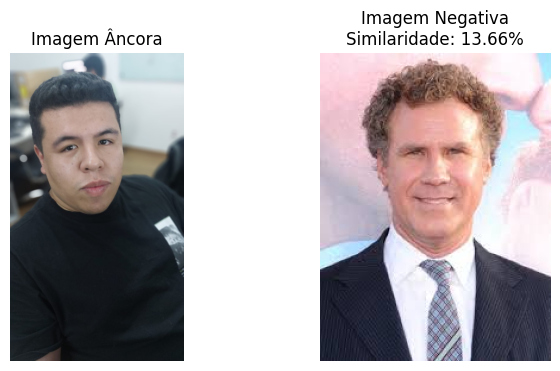

In [426]:
def euclidean_distance(emb1, emb2):
    return tf.reduce_sum(tf.square(emb1 - emb2), axis=-1)


def show_images_with_similarity(img_anc, img_similar, similarity, title_similar):
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    
    # Exibindo a imagem âncora
    axes[0].imshow(img_anc)
    axes[0].set_title("Imagem Âncora")
    axes[0].axis('off')

    # Exibindo a imagem mais semelhante (positiva ou negativa)
    axes[1].imshow(img_similar)
    axes[1].set_title(f"{title_similar}\nSimilaridade: {similarity:.2f}%")
    axes[1].axis('off')

    plt.show()

# Carregar as imagens corretamente com PIL
img_anc = Image.open('data\\00014016290\\anchor\\ff.jpeg')
img_pos = Image.open('data\\00014016290\positive\\gg.jpeg')
img_neg = Image.open('data\\00014016290\\negative\Will Ferrell - AdoroCinema.jpg')

# Cálculo das distâncias
pos_dist = euclidean_distance(emb_anc, emb_pos)
neg_dist = euclidean_distance(emb_anc, emb_neg)


# Exibindo os resultados com conversão para escalar
print(f'Distância âncora-positivo: {(pos_dist.numpy()[0] * 100):.2f} %')
print(f'Distância âncora-negativo: {(neg_dist.numpy()[0] * 100):.2f} %')


if pos_dist < neg_dist:
    print("Imagens positivas e âncora são mais semelhantes.")
    show_images_with_similarity(img_anc, img_pos, pos_dist.numpy().item(), "Imagem Positiva")
else:
    print("Imagens negativas e âncora são mais semelhantes.")
    show_images_with_similarity(img_anc, img_neg, (neg_dist*100).numpy().item(), "Imagem Negativa")
